# Exploratory Data Analysis for Google Time‑Series Dataset
This notebook performs a thorough exploratory data analysis (EDA) of a time‑series dataset that combines Google stock prices with Reddit and news sentiment metrics. The objectives are:
1. Understand the structure and quality of the dataset.
2. Explore temporal patterns in price, volume, and sentiment.
3. Identify relationships between sentiment and market performance.
4. Surface any anomalies, trends, or seasonality that may inform downstream modeling.

In [1]:
# Core
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates

# Stats / TS analysis
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from pandas.plotting import lag_plot, autocorrelation_plot

# Config
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['axes.grid'] = True
sns.set_style('whitegrid')

# Display settings
pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', lambda x: f'{x:,.4f}')

In [2]:
DATA_PATH = '../../data/merged-data/google-merged.csv'

In [3]:
data = pd.read_csv(DATA_PATH)
print(f'Shape: {data.shape}')
data.head()

Shape: (331, 16)


,Date,Open,High,Low,Close,Volume,author,score,subreddit,tickers_mentioned,clean_text,compound,sentiment,cleaned_headline,sentiment_news,sentiment_score
0,2025-01-02,190.4307,191.7791,187.2843,189.2121,"20,370,800.0000",NaN,NaN,NaN,GOOGL,NaN,NaN,NaN,NaN,NaN,NaN
1,2025-01-03,191.1499,192.9877,189.7615,191.5694,"18,596,200.0000",NaN,NaN,NaN,GOOGL,NaN,NaN,NaN,NaN,NaN,NaN
2,2025-01-06,193.7568,197.9920,193.6270,196.6435,"29,563,600.0000",NaN,NaN,NaN,GOOGL,NaN,NaN,NaN,NaN,NaN,NaN
3,2025-01-07,196.8833,200.7688,194.3761,195.2651,"26,487,200.0000",NaN,NaN,NaN,GOOGL,NaN,NaN,NaN,NaN,NaN,NaN
4,2025-01-08,192.3485,196.0642,192.1587,193.7269,"24,864,800.0000",NaN,NaN,NaN,GOOGL,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
display(data.info())

NameError: name 'df' is not defined

In [5]:
display(data.describe(include='all').transpose())

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
Date,331,102,2025-05-22,82,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Open,331.0000,NaN,NaN,NaN,170.7481,9.2101,141.5500,166.4300,171.3500,171.8500,203.1560
High,331.0000,NaN,NaN,NaN,173.7861,9.0910,148.9500,169.9600,173.1700,176.7700,206.8118
Low,331.0000,NaN,NaN,NaN,168.9029,9.3742,140.5300,163.5600,170.0000,170.7100,202.5767
Close,331.0000,NaN,NaN,NaN,170.5276,9.1498,144.7000,167.9931,170.8700,171.8600,206.1426
Volume,331.0000,NaN,NaN,NaN,"48,769,257.4018","19,934,837.2012","17,174,900.0000","32,686,900.0000","43,604,000.0000","74,864,400.0000","127,490,100.0000"
author,155,11,solid-sock-1794,42,NaN,NaN,NaN,NaN,NaN,NaN,NaN
score,155.0000,NaN,NaN,NaN,368.3806,497.3696,0.0000,38.0000,46.0000,"1,189.0000","1,189.0000"
subreddit,155,3,wallstreetbets,93,NaN,NaN,NaN,NaN,NaN,NaN,NaN
tickers_mentioned,331,1,GOOGL,331,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [6]:
data['Date'] = pd.to_datetime(data['Date'])
data = data.sort_values('Date').set_index('Date')

In [7]:
# Forward fill numeric columns if small gaps, else leave for modeling
data[['Open','High','Low','Close','Volume']] = data[['Open','High','Low','Close','Volume']].ffill()

In [8]:
# Create a daily return column
data['Return'] = data['Close'].pct_change()

In [9]:
missing_after = data.isna().sum().sort_values(ascending=False)
print('Missing after preprocessing:')
display(missing_after[missing_after > 0])

Missing after preprocessing:


author              176
score               176
subreddit           176
clean_text          176
compound            176
sentiment           176
cleaned_headline     94
sentiment_news       94
sentiment_score      94
Return                1
dtype: int64

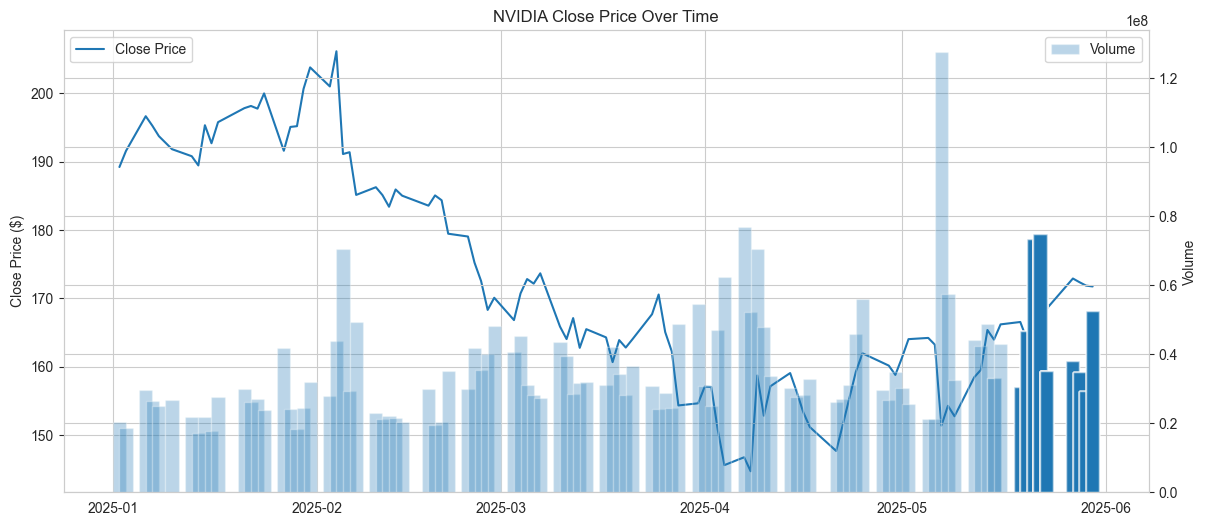

In [10]:
fig, ax1 = plt.subplots(figsize = (14,6))
ax1.plot(data.index, data['Close'], label = 'Close Price')
ax1.set_ylabel('Close Price ($)')
ax1.set_title('NVIDIA Close Price Over Time')
ax1.legend(loc = 'upper left')

# Secondary axis for volume
ax2 = ax1.twinx()
ax2.bar(data.index, data['Volume'], alpha = 0.3, label = 'Volume', width = 2)
ax2.set_ylabel('Volume')
ax2.legend(loc = 'upper right')
plt.show()

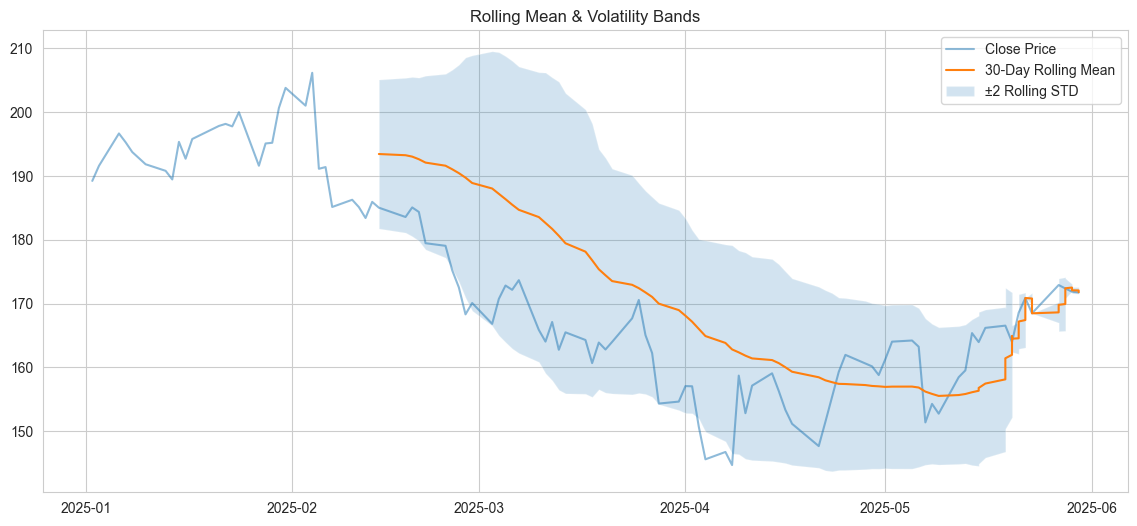

In [11]:
window = 30  # 30 trading days ~ 1.5 months
rolling_mean = data['Close'].rolling(window).mean()
rolling_std = data['Close'].rolling(window).std()

plt.figure(figsize=(14,6))
plt.plot(data['Close'], label='Close Price', alpha=0.5)
plt.plot(rolling_mean, label=f'{window}-Day Rolling Mean')
plt.fill_between(data.index, rolling_mean - 2*rolling_std, rolling_mean + 2*rolling_std, alpha=0.2, label='±2 Rolling STD')
plt.title('Rolling Mean & Volatility Bands')
plt.legend()
plt.show()

In [12]:
data

,Open,High,Low,Close,Volume,author,score,subreddit,tickers_mentioned,clean_text,compound,sentiment,cleaned_headline,sentiment_news,sentiment_score,Return
Date,,,,,,,,,,,,,,,,
2025-01-02,190.4307,191.7791,187.2843,189.2121,"20,370,800.0000",NaN,NaN,NaN,GOOGL,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2025-01-03,191.1499,192.9877,189.7615,191.5694,"18,596,200.0000",NaN,NaN,NaN,GOOGL,NaN,NaN,NaN,NaN,NaN,NaN,0.0125
2025-01-06,193.7568,197.9920,193.6270,196.6435,"29,563,600.0000",NaN,NaN,NaN,GOOGL,NaN,NaN,NaN,NaN,NaN,NaN,0.0265
2025-01-07,196.8833,200.7688,194.3761,195.2651,"26,487,200.0000",NaN,NaN,NaN,GOOGL,NaN,NaN,NaN,NaN,NaN,NaN,-0.0070
2025-01-08,192.3485,196.0642,192.1587,193.7269,"24,864,800.0000",NaN,NaN,NaN,GOOGL,NaN,NaN,NaN,NaN,NaN,NaN,-0.0079
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-05-30,171.3500,172.2100,167.4400,171.7400,"52,639,900.0000",NaN,NaN,NaN,GOOGL,NaN,NaN,NaN,stock market today markets surge as court bloc...,positive,0.9057,0.0000
2025-05-30,171.3500,172.2100,167.4400,171.7400,"52,639,900.0000",NaN,NaN,NaN,GOOGL,NaN,NaN,NaN,c3ai eyes 47 billion agentic ai market by 2030...,positive,0.7274,0.0000
2025-05-30,171.3500,172.2100,167.4400,171.7400,"52,639,900.0000",NaN,NaN,NaN,GOOGL,NaN,NaN,NaN,these 4 quantum stocks outperformed in mayis t...,positive,0.8719,0.0000


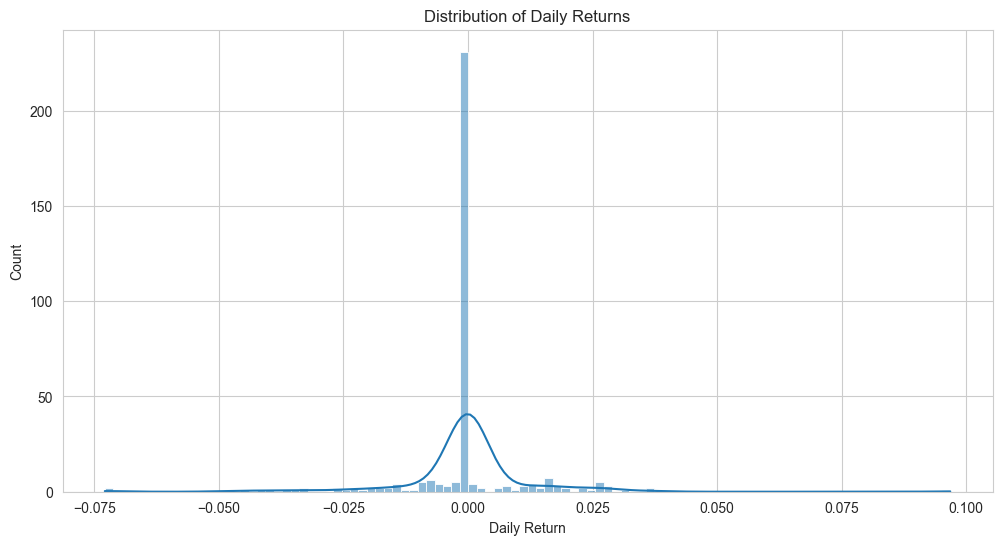

count   330.0000
mean     -0.0002
std       0.0131
min      -0.0729
1%       -0.0440
5%       -0.0191
25%       0.0000
50%       0.0000
75%       0.0000
95%       0.0190
99%       0.0302
max       0.0968
Name: Return, dtype: float64

In [13]:
sns.histplot(data['Return'].dropna(), bins=100, kde=True)
plt.title('Distribution of Daily Returns')
plt.xlabel('Daily Return')
plt.show()

# Tail analysis
data['Return'].describe(percentiles=[.01,.05,.25,.5,.75,.95,.99])

In [14]:
def adf_test(series, title=''):
    print(f'Augmented Dickey-Fuller Test: {title}')
    result = adfuller(series.dropna(), autolag='AIC')
    labels = ['ADF Statistic', 'p-value', '# Lags Used', 'Number of Observations Used']
    out = dict(zip(labels, result[:4]))
    for key, value in out.items():
        print(f'{key}: {value}')
    for key, val in result[4].items():
        print(f'Critical Value {key}: {val}')
    print('---')

adf_test(data['Close'], 'Close Price')
adf_test(data['Return'], 'Return')

Augmented Dickey-Fuller Test: Close Price
ADF Statistic: -3.8961489925484054
p-value: 0.0020633719054667645
# Lags Used: 15
Number of Observations Used: 315
Critical Value 1%: -3.451281394993741
Critical Value 5%: -2.8707595072926293
Critical Value 10%: -2.571682118921643
---
Augmented Dickey-Fuller Test: Return
ADF Statistic: -3.1747547186885243
p-value: 0.02149327428521212
# Lags Used: 17
Number of Observations Used: 312
Critical Value 1%: -3.4514843502727306
Critical Value 5%: -2.8708485956333556
Critical Value 10%: -2.571729625657462
---


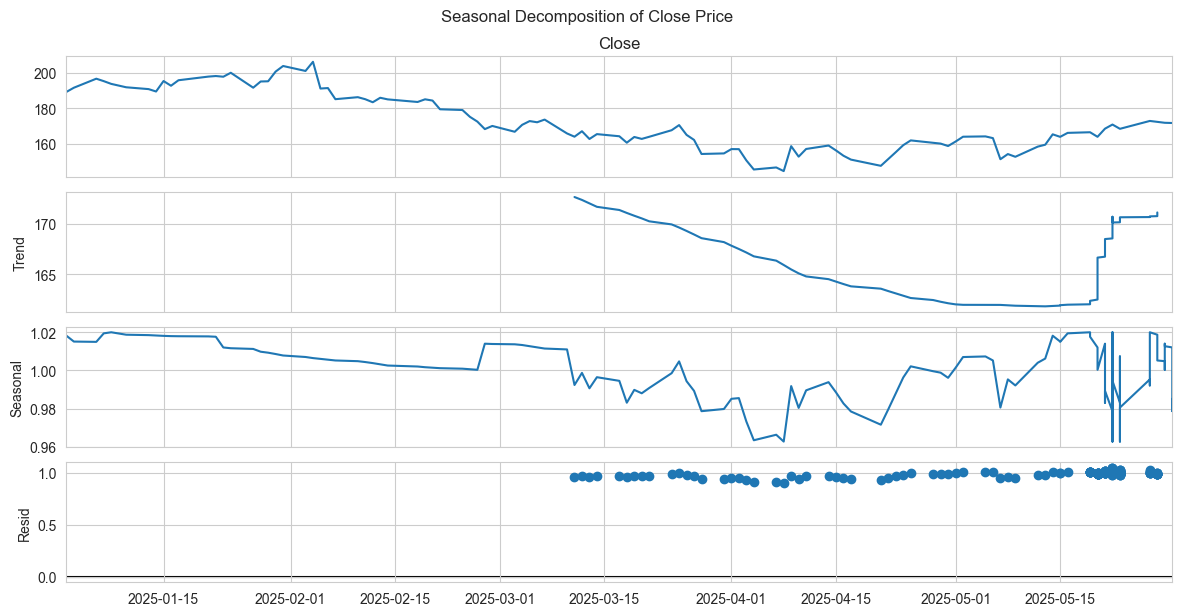

In [17]:
# Decompose with multiplicative model (price often multiplicative)
decomposition = seasonal_decompose(data['Close'], model = 'multiplicative', period = 90)

decomposition.plot()
plt.suptitle('Seasonal Decomposition of Close Price', y = 1.02)
plt.show()

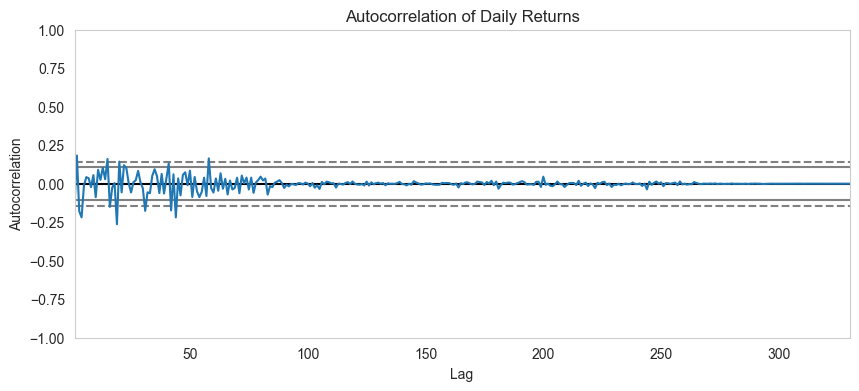

In [18]:
plt.figure(figsize=(10,4))
autocorrelation_plot(data['Return'].dropna())
plt.title('Autocorrelation of Daily Returns')
plt.show()

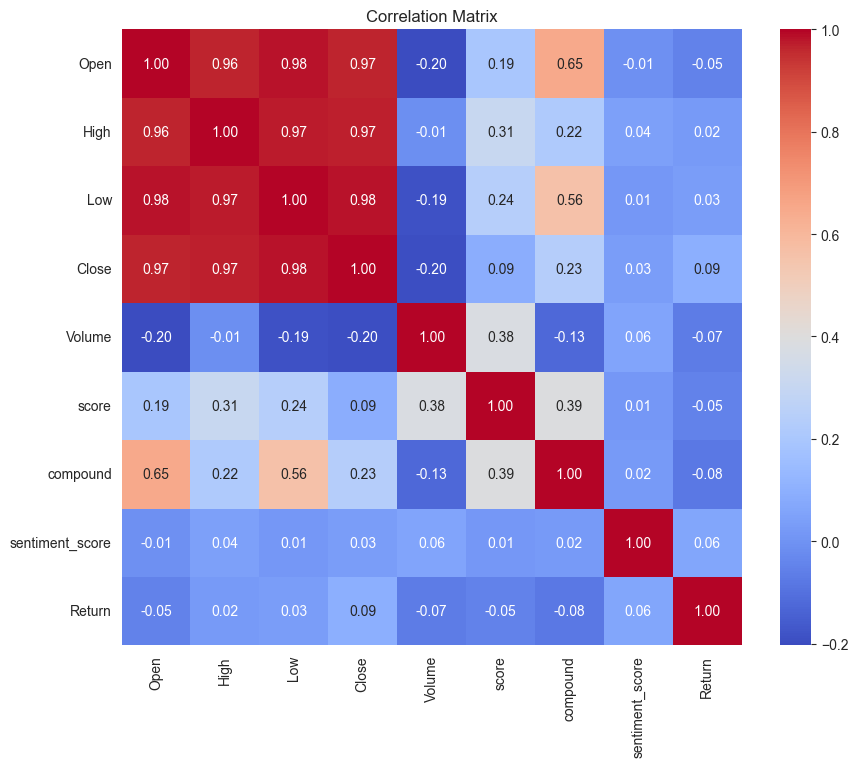

In [19]:
# Select numeric columns for correlation
num_cols = data.select_dtypes(include=[np.number]).columns
plt.figure(figsize=(10,8))
sns.heatmap(data[num_cols].corr(), annot=True, fmt='.2f', cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

In [20]:
# How many duplicates do I have?
dupes = data.index.duplicated(keep=False).sum()
print(f"Duplicate index rows: {dupes}")

# Quickly inspect a few of them
print(data.index[data.index.duplicated()].unique()[:10])


Duplicate index rows: 239
DatetimeIndex(['2025-05-15', '2025-05-19', '2025-05-20', '2025-05-21',
               '2025-05-22', '2025-05-23', '2025-05-27', '2025-05-28',
               '2025-05-29', '2025-05-30'],
              dtype='datetime64[ns]', name='Date', freq=None)


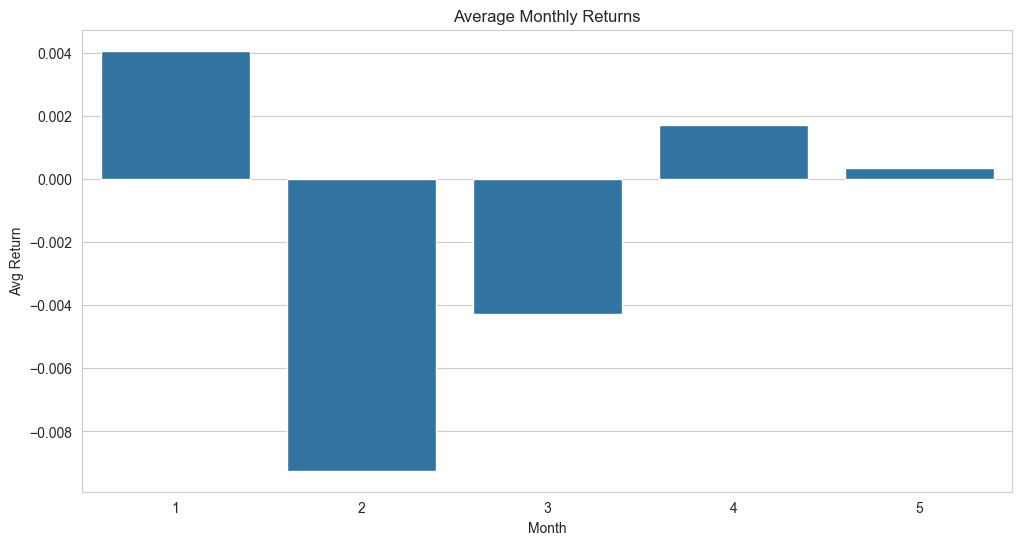

In [22]:
# Monthly seasonality
data['Month'] = data.index.month
monthly_avg = data.groupby('Month')['Return'].mean()

sns.barplot(x=monthly_avg.index, y=monthly_avg.values)
plt.title('Average Monthly Returns')
plt.xlabel('Month')
plt.ylabel('Avg Return')
plt.show()

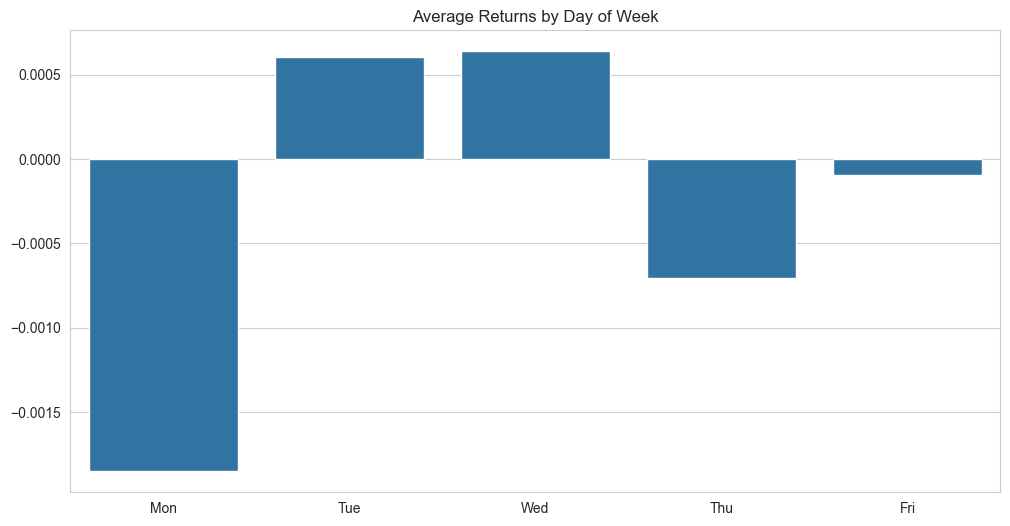

In [23]:
# Day of week effect
data['DayOfWeek'] = data.index.dayofweek  # 0=Monday
dow_avg = data.groupby('DayOfWeek')['Return'].mean()

sns.barplot(x=['Mon','Tue','Wed','Thu','Fri'], y=dow_avg.values)
plt.title('Average Returns by Day of Week')
plt.show()